In [10]:
## load packages 
import pandas as pd
import re
import numpy as np
import plotnine
from plotnine import *

## nltk imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

## sklearn imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## random
import random

pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [11]:
df_sirs = pd.read_excel('Dartmouth Data Set- SIRS .xlsx')

In [44]:
xls = pd.ExcelFile('Dartmouth Data Set- SIRS .xlsx')
df1 = pd.read_excel(xls, 'Emergency Crisis Services')
df_dem = pd.read_excel(xls, 'Demographics')

In [139]:
df_dem1 = df_dem[['Local ID', 'Gender', 'Race', 'Ethnicity',
       'Level of Intellectual Disability',
       'Current living situation at enrollment to START',
       'More than one living situation over the last 5 years?',
       'More than one living situation over the last year?']]

In [140]:
# Taking top 96% of data
def categorize_race(race):
    categories = {
        'White': ['White', 'Other: Middle Eastern'],
        'Black/African American': ['Black or African American'],
        'Other/Unknown': ['Unknown, not collected', 'Other', 'Unknown, not collected, White', 'Other: Biracial'],
        'Hispanic/Latinx': ['Other: Hispanic', 'Other: Latino', 'Other: hispanic', 'Other: Mexican'],
        'Asian/Pacific Islander': ['Asian', 'Native Hawaiian or Other Pacific Islander'],
        'Mixed': ['Black or African American, White', 'Asian, White'],
        'American Indian or Alaska Native': ['American Indian or Alaska Native'],
    }

    for category, labels in categories.items():
        if race in labels:
            return category
    return 'Other/Unknown'

In [141]:
df_dem1['race_clean'] = df_dem1['Race'].apply(categorize_race)
df_dem1.race_clean.value_counts()

/var/folders/62/q5cwr8p541q40q2zbtg90hxh0000gn/T/ipykernel_17823/3560702309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


race_clean
White                               2984
Black/African American               994
Other/Unknown                        529
Hispanic/Latinx                      250
Asian/Pacific Islander               155
Mixed                                 47
American Indian or Alaska Native      27
Name: count, dtype: int64

In [142]:
df1.keys()
date = 'Date/Time of Contact'
hospital_diversion = "Did START response prevent higher level of care (hospital diversion)"

Index(['Individual ID', 'Date/Time of Contact', 'Source of Contact',
       'Reason for Contact', 'Type of Emergency Response',
       'Total episode length (initial call to disposition)',
       'Total response time (initial call to arrival on-site)', 'Travel Time',
       'Police Response', 'If Police Responded', 'Who Contacted Police?',
       'Mobile Crisis', 'If Mobile Crisis', 'Restraints Used',
       'If Restraints Were Used', 'Disposition', 'Disposition Information',
       'Admitted through ED/CPEP', 'Date of Admission',
       'Disposition Information (ER)',
       'Did START response prevent higher level of care (hospital diversion)',
       'RSQ Completed?'],
      dtype='object')

In [144]:
df1[hospital_diversion].value_counts()

Did START response prevent higher level of care (hospital diversion)
No     10237
Yes     7931
Name: count, dtype: int64

In [145]:
df1_clean = df1[["Individual ID", date, hospital_diversion, "Reason for Contact"]].copy()

In [146]:
df1_clean["Reason for Contact"] = df1_clean["Reason for Contact"].str.replace("Aggression (physical, verbal, property destruction, threats)", "Aggression")
df1_clean['Reason for Contact'] = df1_clean['Reason for Contact'].str.lower()
df1_clean["Reason for Contact"] = df1_clean["Reason for Contact"].str.replace(r'(other:)?\s*?(change\s*(of|in)?\s*)?mood(\s*change)?', 'mood change', regex=True)


In [147]:
df1_clean['Reason for Contact'].fillna("Unknown", inplace=True)

In [148]:
def checker(df, word):
    # Create the 'is_blank' column based on whether 'Reason for Contact' contains the word
    column_name = 'is_' + str(word)
    print(column_name)
    df[column_name] = df['Reason for Contact'].str.contains(word)
    return df


In [149]:
categories = ['aggression', 'mental health', 'family needs assistance', 'suicidal', 'self-injurious', 'daily functions', 'risk of losing placement', 'mood']

df2 = df1_clean.apply(lambda row: pd.Series({
    'Individual ID': row['Individual ID'],
    'Date/Time of Contact': row['Date/Time of Contact'],
    'Reason for Contact': row['Reason for Contact'],
    'Did START response prevent higher level of care (hospital diversion)': row['Did START response prevent higher level of care (hospital diversion)'],
    **{f'is_{cat}': cat.lower() in row['Reason for Contact'].lower() for cat in categories}
}), axis=1)


In [150]:
df2['is_other'] = df2['Reason for Contact'].apply(lambda x: True if 'other' in x.lower() else False)

In [151]:
df2

,Individual ID,Date/Time of Contact,Reason for Contact,Did START response prevent higher level of care (hospital diversion),is_aggression,is_mental health symptoms,is_family needs assistance,is_suicidal,is_self-injurious,is_daily functions,is_risk of losing placement,is_mood,is_other
0,11153125,2016-08-16 08:40:00,"at risk of losing placement, other, self-injurious",No,False,False,False,False,True,False,True,False,True
1,11153125,2018-04-27 15:00:00,"mental health symptoms, self-injurious",Yes,False,True,False,False,True,False,False,False,False
2,11153125,2018-06-05 16:00:00,"mental health symptoms, suicidal ideation/behaviors",Yes,False,True,False,True,False,False,False,False,False
3,11158347,2015-06-01 14:00:00,"diagnosis and treatment plan assistance, other: facilitating med ajustment w/ center",No,False,False,False,False,False,False,False,False,True
4,11158347,2015-06-01 16:00:00,"aggression, family needs assistance, mental health symptoms",No,True,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18163,108482C,2021-12-03 14:05:00,"aggression, mental health symptoms",Yes,True,True,False,False,False,False,False,False,False
18164,817731C,2021-12-04 14:21:00,"family needs assistance, mental health symptoms",Yes,False,True,True,False,False,False,False,False,False
18165,471473,2021-12-19 15:00:00,mental health symptoms,No,False,True,False,False,False,False,False,False,False
18166,780879W,2021-12-17 11:00:00,"at risk of losing placement, decrease in ability to participate in daily functions, diagnosis and treatment plan assistance, mental health symptoms, self-injurious, suicidal ideation/behaviors",No,False,True,False,True,True,True,True,False,False


In [152]:
df1_clean['Reason for Contact'].str.split(', ').explode().str.lower().value_counts(normalize=True).head(30)

Reason for Contact
aggression                                                  0.325284
mental health symptoms                                      0.196120
family needs assistance                                     0.118616
suicidal ideation/behaviors                                 0.060850
self-injurious                                              0.055545
decrease in ability to participate in daily functions       0.049069
at risk of losing placement                                 0.028343
other                                                       0.020047
mood change                                                 0.019954
transition from hospital                                    0.012367
medical concerns                                            0.009345
other: leaving unexpectedly                                 0.007865
diagnosis and treatment plan assistance                     0.006415
unknown                                                     0.005706
medication eval

In [153]:
df2.keys()
df_dem1.keys()

Index(['Individual ID', 'Date/Time of Contact', 'Reason for Contact',
       'Did START response prevent higher level of care (hospital diversion)',
       'is_aggression', 'is_mental health symptoms',
       'is_family needs assistance', 'is_suicidal', 'is_self-injurious',
       'is_daily functions', 'is_risk of losing placement', 'is_mood',
       'is_other'],
      dtype='object')

Index(['Local ID', 'Gender', 'Race', 'Ethnicity',
       'Level of Intellectual Disability',
       'Current living situation at enrollment to START',
       'More than one living situation over the last 5 years?',
       'More than one living situation over the last year?', 'race_clean'],
      dtype='object')

In [162]:
df_dem2.keys()

Index(['Local ID', 'Gender', 'is_Asian/Pacific Islander', 'is_White',
       'is_Hispanic/Latinx', 'is_American Indian or Alaska Native',
       'is_Black/African American', 'is_Other/Unknown', 'is_Mixed'],
      dtype='object')

In [221]:
races = ['Asian/Pacific Islander', 'White', 'Hispanic/Latinx',
       'American Indian or Alaska Native', 'Black/African American',
       'Other/Unknown', 'Mixed']
df_dem2 = df_dem1.apply(lambda row: pd.Series({
    'Local ID': row['Local ID'],
    'Gender': row['Gender'],
    **{f'{cat}': cat.lower() in row['race_clean'].lower() for cat in races}
}), axis=1)


In [222]:
df_dem2

,Local ID,Gender,Asian/Pacific Islander,White,Hispanic/Latinx,American Indian or Alaska Native,Black/African American,Other/Unknown,Mixed
0,11128335,Male,True,False,False,False,False,False,False
1,11134104,Female,False,True,False,False,False,False,False
2,11138520,Female,False,True,False,False,False,False,False
3,11132094,Male,False,True,False,False,False,False,False
4,975134C,Female,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
4981,64995,Male,False,True,False,False,False,False,False
4982,366747,Female,False,True,False,False,False,False,False
4983,40366,Male,False,True,False,False,False,False,False
4984,11150993,Male,False,True,False,False,False,False,False


In [306]:
df_merged = pd.merge(df2, df_dem2, left_on="Individual ID", right_on= "Local ID", how='inner')


df_merged.replace({'Yes': 1, 'No': 0}, inplace=True)
df_merged

,Individual ID,Date/Time of Contact,Reason for Contact,Did START response prevent higher level of care (hospital diversion),is_aggression,is_mental health symptoms,is_family needs assistance,is_suicidal,is_self-injurious,is_daily functions,...,is_other,Local ID,Gender,Asian/Pacific Islander,White,Hispanic/Latinx,American Indian or Alaska Native,Black/African American,Other/Unknown,Mixed
0,11153125,2016-08-16 08:40:00,"at risk of losing placement, other, self-injurious",0,False,False,False,False,True,False,...,True,11153125,Female,False,True,False,False,False,False,False
1,11153125,2018-04-27 15:00:00,"mental health symptoms, self-injurious",1,False,True,False,False,True,False,...,False,11153125,Female,False,True,False,False,False,False,False
2,11153125,2018-06-05 16:00:00,"mental health symptoms, suicidal ideation/behaviors",1,False,True,False,True,False,False,...,False,11153125,Female,False,True,False,False,False,False,False
3,11153125,2019-07-18 10:30:00,"diagnosis and treatment plan assistance, mental health symptoms, suicidal ideation/behaviors",0,False,True,False,True,False,False,...,False,11153125,Female,False,True,False,False,False,False,False
4,11153125,2019-07-17 17:35:00,"self-injurious, suicidal ideation/behaviors",1,False,False,False,True,True,False,...,False,11153125,Female,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14488,167376,2021-12-08 09:30:00,"aggression, decrease in ability to participate in daily functions",1,True,False,False,False,False,True,...,False,167376,Male,False,False,False,False,True,False,False
14489,383243E,2021-12-10 10:45:00,"aggression, at risk of losing placement, mental health symptoms",0,True,True,False,False,False,False,...,False,383243E,Male,False,True,False,False,False,False,False
14490,809219C,2021-12-10 16:20:00,"aggression, family needs assistance",1,True,False,True,False,False,False,...,False,809219C,Male,False,True,False,False,False,False,False
14491,407330,2021-12-15 10:28:00,"other: summer did not show up to school and given concerns with safety, the school was concerned. mom was not answering the phone",0,False,False,False,False,False,False,...,True,407330,Female,False,True,False,False,False,False,False


In [224]:
df_pre = df_merged[(df_merged['Date/Time of Contact'] > '2019-03-01 00:00:00') & (df_merged['Date/Time of Contact'] < '2020-03-12 00:00:00')]

In [225]:
df_post = df_merged[(df_merged['Date/Time of Contact'] > '2020-03-13 00:00:00') & (df_merged['Date/Time of Contact'] < '2021-03-01 00:00:00')]

In [226]:
df_merged

,Individual ID,Date/Time of Contact,Reason for Contact,Did START response prevent higher level of care (hospital diversion),is_aggression,is_mental health symptoms,is_family needs assistance,is_suicidal,is_self-injurious,is_daily functions,...,is_other,Local ID,Gender,Asian/Pacific Islander,White,Hispanic/Latinx,American Indian or Alaska Native,Black/African American,Other/Unknown,Mixed
0,11153125,2016-08-16 08:40:00,"at risk of losing placement, other, self-injurious",0,False,False,False,False,True,False,...,True,11153125,Female,False,True,False,False,False,False,False
1,11153125,2018-04-27 15:00:00,"mental health symptoms, self-injurious",1,False,True,False,False,True,False,...,False,11153125,Female,False,True,False,False,False,False,False
2,11153125,2018-06-05 16:00:00,"mental health symptoms, suicidal ideation/behaviors",1,False,True,False,True,False,False,...,False,11153125,Female,False,True,False,False,False,False,False
3,11153125,2019-07-18 10:30:00,"diagnosis and treatment plan assistance, mental health symptoms, suicidal ideation/behaviors",0,False,True,False,True,False,False,...,False,11153125,Female,False,True,False,False,False,False,False
4,11153125,2019-07-17 17:35:00,"self-injurious, suicidal ideation/behaviors",1,False,False,False,True,True,False,...,False,11153125,Female,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14488,167376,2021-12-08 09:30:00,"aggression, decrease in ability to participate in daily functions",1,True,False,False,False,False,True,...,False,167376,Male,False,False,False,False,True,False,False
14489,383243E,2021-12-10 10:45:00,"aggression, at risk of losing placement, mental health symptoms",0,True,True,False,False,False,False,...,False,383243E,Male,False,True,False,False,False,False,False
14490,809219C,2021-12-10 16:20:00,"aggression, family needs assistance",1,True,False,True,False,False,False,...,False,809219C,Male,False,True,False,False,False,False,False
14491,407330,2021-12-15 10:28:00,"other: summer did not show up to school and given concerns with safety, the school was concerned. mom was not answering the phone",0,False,False,False,False,False,False,...,True,407330,Female,False,True,False,False,False,False,False


In [307]:
df_merged['Date/Time of Contact'] = pd.to_datetime(df_merged['Date/Time of Contact'])
df_merged.set_index('Date/Time of Contact', inplace=True)


In [317]:
# Group by week and aggregate specific columns differently
weekly_grouped = df_merged.resample('M').agg({
    'Individual ID': 'count',  # Count of entries per week
    'is_aggression': 'sum',
    'is_mental health' : 'sum',
    'is_family needs assistance' : 'sum',
    'is_suicidal' : 'sum',
    'is_self-injurious' : 'sum',
    'is_daily functions' : 'sum',
    'is_risk of losing placement' : 'sum',
    'is_mood' : 'sum',
    'is_other' : 'sum',
    'Did START response prevent higher level of care (hospital diversion)' : 'sum',
    'Asian/Pacific Islander': 'sum',
    'White' : 'sum',
    'Hispanic/Latinx' : 'sum',
    'American Indian or Alaska Native' : 'sum',
    'Black/African American' : 'sum',
    'Other/Unknown' : 'sum',
    'Mixed' : 'sum'
    
})

# Reset the index if you want 'Date/Time of Contact' back as a column
weekly_grouped.reset_index(inplace=True)

weekly_grouped = weekly_grouped[(weekly_grouped['Date/Time of Contact'] > '2019-03-02 00:00:00')]


In [318]:
weekly_grouped

,Date/Time of Contact,Individual ID,is_aggression,is_mental health symptoms,is_family needs assistance,is_suicidal,is_self-injurious,is_daily functions,is_risk of losing placement,is_mood,is_other,Did START response prevent higher level of care (hospital diversion),Asian/Pacific Islander,White,Hispanic/Latinx,American Indian or Alaska Native,Black/African American,Other/Unknown,Mixed
71,2019-03-31,209,123,67,27,31,28,14,5,14,43,109,4,123,18,4,51,8,1
72,2019-04-30,222,153,63,47,36,40,17,8,25,35,125,3,126,7,2,72,11,1
73,2019-05-31,246,160,76,59,25,33,14,9,31,39,153,4,116,12,5,81,28,0
74,2019-06-30,227,152,76,55,29,38,14,9,31,27,138,1,127,10,2,71,15,1
75,2019-07-31,214,157,71,51,28,30,12,7,15,31,130,4,133,10,3,50,13,1
76,2019-08-31,243,162,65,61,39,26,7,4,22,31,164,3,151,10,2,46,28,3
77,2019-09-30,278,175,80,77,32,29,18,10,39,37,197,0,189,9,3,49,25,3
78,2019-10-31,274,181,78,47,35,38,19,3,63,38,189,3,166,5,7,60,30,3
79,2019-11-30,260,171,82,46,37,20,18,9,28,31,172,2,178,5,6,51,16,2
80,2019-12-31,243,149,100,56,45,29,13,9,24,32,141,0,163,18,2,43,17,0


<Figure size 1400x700 with 0 Axes>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

Text(0.5, 1.0, 'Monthly Sum of Categorical Events')

Text(0.5, 0, 'Monthly')

Text(0, 0.5, 'Count')

(array([18017., 18140., 18262., 18383., 18506., 18628., 18748., 18871.,
        18993.]),
 [Text(18017.0, 0, '2019-05'),
  Text(18140.0, 0, '2019-09'),
  Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01')])

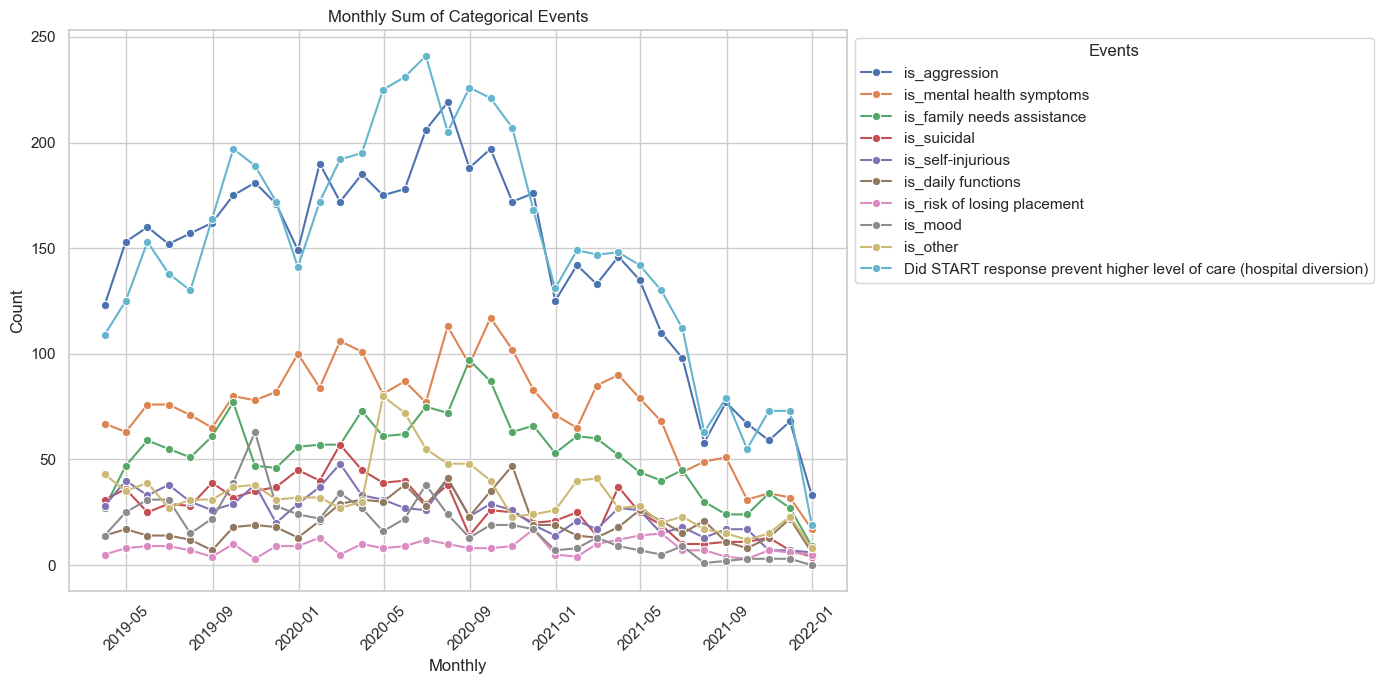

In [319]:
plt.figure(figsize=(14, 7))

# Plot each categorical column
for column in weekly_grouped.columns[2:12]:
    sns.lineplot(x='Date/Time of Contact', y=column, data=weekly_grouped, marker='o', label=column)

plt.title('Monthly Sum of Categorical Events')
plt.xlabel('Monthly')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Events')
plt.tight_layout()
plt.show()

In [320]:
# Normalize each 'is_...' column by 'Individual ID' counts
cols_to_normalize = weekly_grouped.columns[2:12]  # Assuming columns to normalize are from the 3rd column onwards

weekly_grouped[cols_to_normalize] = weekly_grouped[cols_to_normalize].div(weekly_grouped['Individual ID'], axis=0)


<Figure size 1400x700 with 0 Axes>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

<Axes: xlabel='Date/Time of Contact', ylabel='is_aggression'>

Text(0.5, 1.0, 'Monthly Proportion of START Reasons for Contact')

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Proportion')

(array([18017., 18140., 18262., 18383., 18506., 18628., 18748., 18871.,
        18993.]),
 [Text(18017.0, 0, '2019-05'),
  Text(18140.0, 0, '2019-09'),
  Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01')])

ConversionError: Failed to convert value(s) to axis units: '2020-02-29'

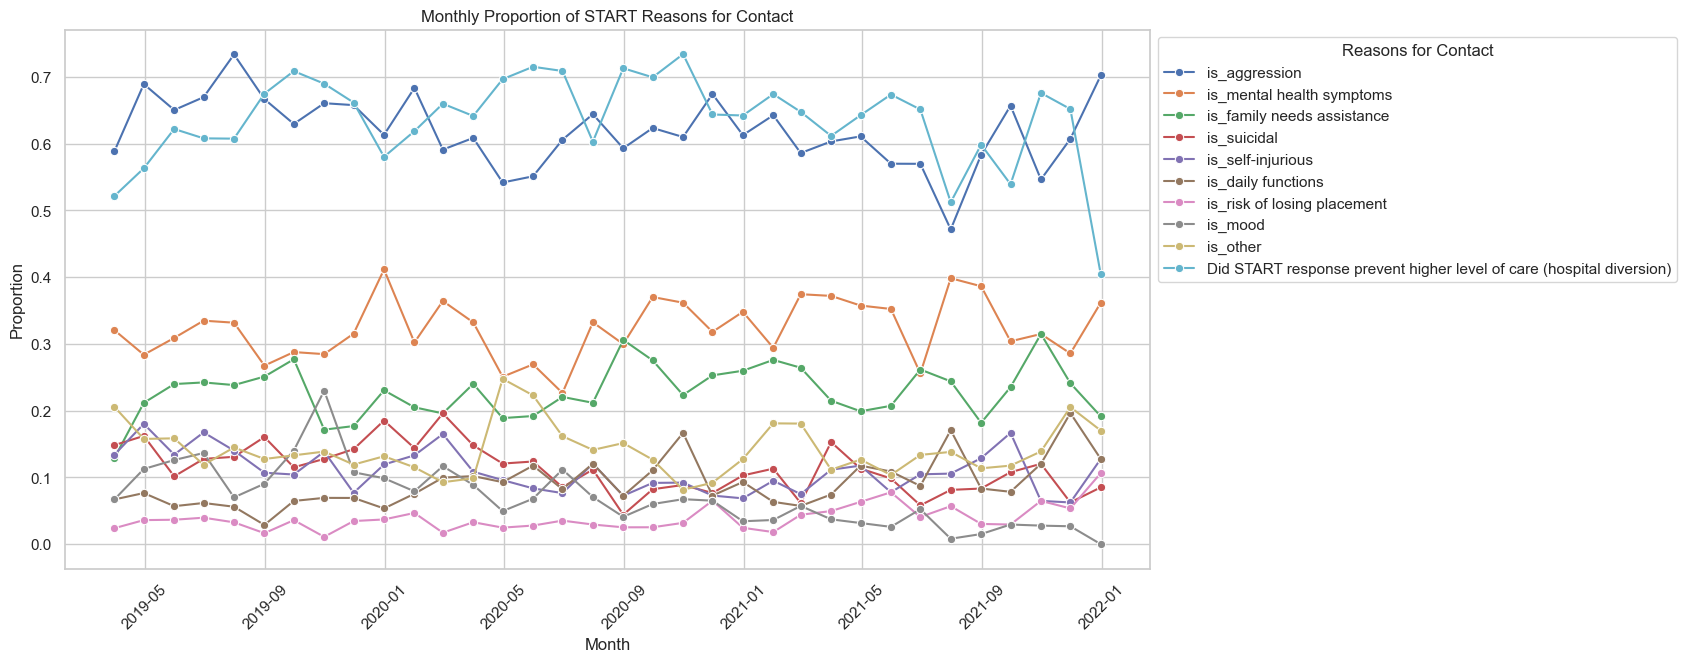

In [322]:

# Set the style
sns.set(style="whitegrid")

# Plot multiple line graphs
plt.figure(figsize=(14, 7))

# Plot each categorical column
for column in cols_to_normalize:
    sns.lineplot(x='Date/Time of Contact', y=column, data=weekly_grouped, marker='o', label=column)

plt.title('Monthly Proportion of START Reasons for Contact')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Reasons for Contact')

# Add a vertical line at March 15, 2020
plt.axvline(x='2020-02-29', color='red', linestyle='--', label='March 15, 2020')

plt.tight_layout()
plt.show()


<Figure size 1400x700 with 0 Axes>

<Axes: xlabel='Date/Time of Contact', ylabel='Individual ID'>

Text(0.5, 1.0, 'Weekly Count of Individual ID')

Text(0.5, 0, 'Week')

Text(0, 0.5, 'Count of Individual ID')

(array([18017., 18140., 18262., 18383., 18506., 18628., 18748., 18871.,
        18993.]),
 [Text(18017.0, 0, '2019-05'),
  Text(18140.0, 0, '2019-09'),
  Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01')])

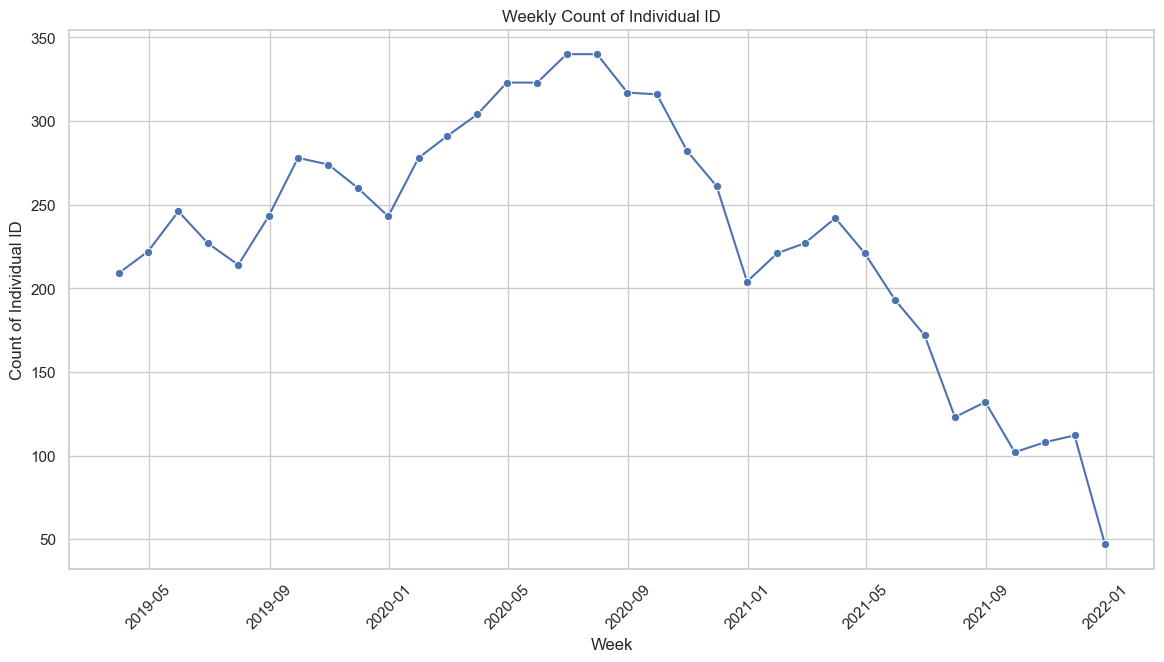

Text(0.5, 1.0, 'Weekly Sum of Categorical Events')

Text(0.5, 0, 'Week')

Text(0, 0.5, 'Count')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 [Text(0, 0, '2019-03-31 00:00:00'),
  Text(1, 0, '2019-04-30 00:00:00'),
  Text(2, 0, '2019-05-31 00:00:00'),
  Text(3, 0, '2019-06-30 00:00:00'),
  Text(4, 0, '2019-07-31 00:00:00'),
  Text(5, 0, '2019-08-31 00:00:00'),
  Text(6, 0, '2019-09-30 00:00:00'),
  Text(7, 0, '2019-10-31 00:00:00'),
  Text(8, 0, '2019-11-30 00:00:00'),
  Text(9, 0, '2019-12-31 00:00:00'),
  Text(10, 0, '2020-01-31 00:00:00'),
  Text(11, 0, '2020-02-29 00:00:00'),
  Text(12, 0, '2020-03-31 00:00:00'),
  Text(13, 0, '2020-04-30 00:00:00'),
  Text(14, 0, '2020-05-31 00:00:00'),
  Text(15, 0, '2020-06-30 00:00:00'),
  Text(16, 0, '2020-07-31 00:00:00'),
  Text(17, 0, '2020-08-31 00:00:00'),
  Text(18, 0, '2020-09-30 00:00:00'),
  Text(19, 0, '2020-10-31 00:00:00'),
  Text(20, 0, '2020-11-30 00:00:00'),
  Text(21, 0, '2020-12-31 00:00:00'),
  Text(22, 0, '2021-

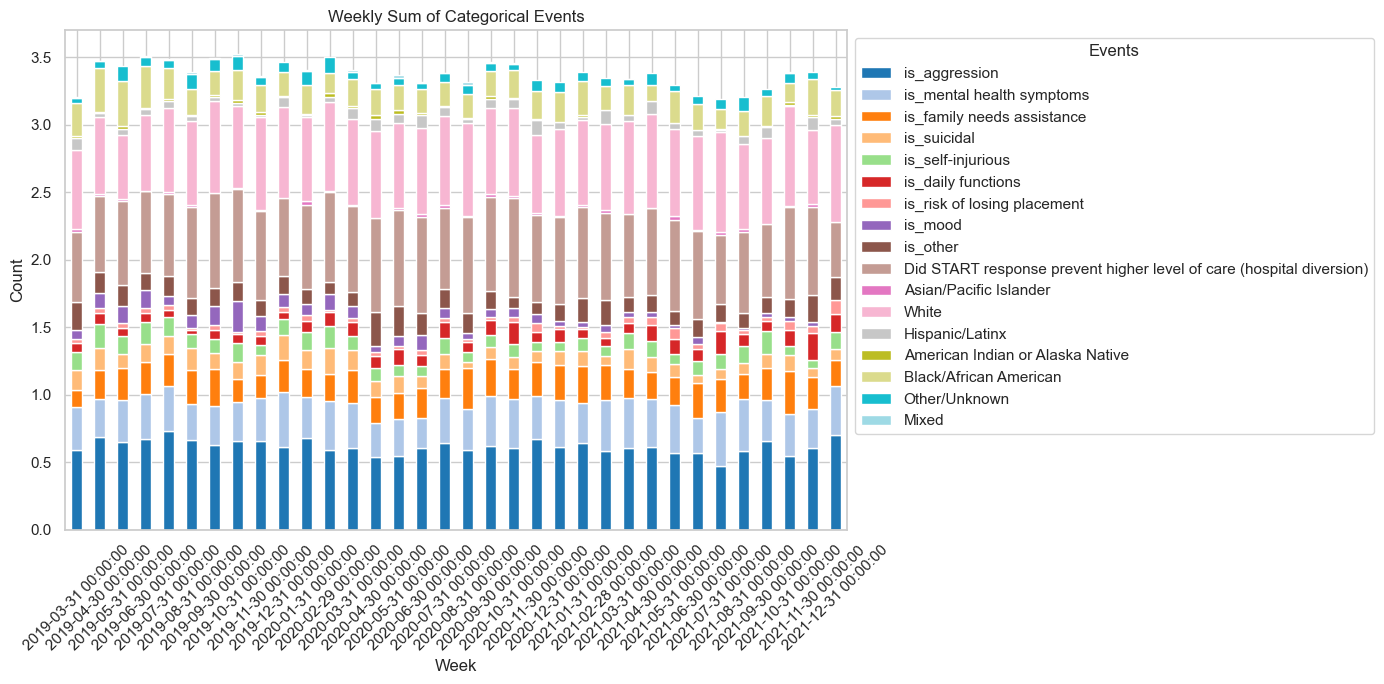

In [231]:
# Line plot for Individual ID
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date/Time of Contact', y='Individual ID', data=weekly_grouped, marker='o')
plt.title('Weekly Count of Individual ID')
plt.xlabel('Week')
plt.ylabel('Count of Individual ID')
plt.xticks(rotation=45)
plt.show()

# Preparing data for the stacked bar chart
df_cat = weekly_grouped.drop(columns=['Individual ID'])
df_cat.set_index('Date/Time of Contact', inplace=True)

# Stacked bar chart for categorical data
ax = df_cat.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20')
plt.title('Weekly Sum of Categorical Events')
plt.xlabel('Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Events')
plt.tight_layout()
plt.show()

In [232]:
weekly_grouped.keys()

Index(['Date/Time of Contact', 'Individual ID', 'is_aggression',
       'is_mental health symptoms', 'is_family needs assistance',
       'is_suicidal', 'is_self-injurious', 'is_daily functions',
       'is_risk of losing placement', 'is_mood', 'is_other',
       'Did START response prevent higher level of care (hospital diversion)',
       'Asian/Pacific Islander', 'White', 'Hispanic/Latinx',
       'American Indian or Alaska Native', 'Black/African American',
       'Other/Unknown', 'Mixed'],
      dtype='object')

In [233]:
regression_problem = 'Did START response prevent higher level of care (hospital diversion)'

# Select features for the regression
feature_names = [
    'is_aggression',
    'is_mental health', 
    'is_family needs assistance',
    'is_suicidal', 
    'is_self-injurious',
    'is_daily functions',
    'is_risk of losing placement', 
    'is_mood', 
    'is_other',
    'Asian/Pacific Islander', 'White',
       'Hispanic/Latinx', 'American Indian or Alaska Native',
       'Black/African American', 'Other/Unknown', 'Mixed'
]

# Assuming `weekly_grouped` is your DataFrame
X = weekly_grouped[feature_names].copy()
y = weekly_grouped[regression_problem].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Make predictions
y_pred = linreg.predict(X_test)

# Calculate mean squared error and R^2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Get the coefficients and feature names
coefficients = linreg.coef_
feature_names = X.columns

# Calculate Pearson correlation coefficients
correlations = []
for feature in feature_names:
    correlation = np.corrcoef(X[feature], y)[0, 1]
    correlations.append(correlation)

# Create a DataFrame to display feature importance and correlations
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'R-value': correlations
}).sort_values(by='Coefficient', ascending=False)

print(f"Feature Impact on {regression_problem} in people with IDD in START program:")
print(feature_importance)

LinearRegression()

Mean Squared Error: 0.012989442196723584
R^2 Score: -7.888226865140474
Feature Impact on Did START response prevent higher level of care (hospital diversion) in people with IDD in START program:
                             Feature  Coefficient   R-value
15                             Mixed     1.026224  0.467798
2         is_family needs assistance     0.814200  0.315538
14                     Other/Unknown     0.557535  0.233714
8                           is_other     0.381879 -0.041507
7                            is_mood     0.339910  0.304554
5                 is_daily functions     0.292989 -0.047182
11                   Hispanic/Latinx     0.220136  0.044505
12  American Indian or Alaska Native     0.180278  0.092455
0                      is_aggression     0.068842 -0.205734
3                        is_suicidal     0.051814 -0.113061
4                  is_self-injurious    -0.277941 -0.505148
1          is_mental health symptoms    -0.371692 -0.392542
9             Asian/Pacif

In [234]:
# Assuming `weekly_grouped` is your DataFrame
X = weekly_grouped[feature_names].copy()
y = weekly_grouped[regression_problem].copy()

# Add a constant term for the intercept
# X = sm.add_constant(X)

In [235]:
df_pre.keys()

Index(['Individual ID', 'Date/Time of Contact', 'Reason for Contact',
       'Did START response prevent higher level of care (hospital diversion)',
       'is_aggression', 'is_mental health symptoms',
       'is_family needs assistance', 'is_suicidal', 'is_self-injurious',
       'is_daily functions', 'is_risk of losing placement', 'is_mood',
       'is_other', 'Local ID', 'Gender', 'Asian/Pacific Islander', 'White',
       'Hispanic/Latinx', 'American Indian or Alaska Native',
       'Black/African American', 'Other/Unknown', 'Mixed'],
      dtype='object')

In [236]:
df_pre.keys()

Index(['Individual ID', 'Date/Time of Contact', 'Reason for Contact',
       'Did START response prevent higher level of care (hospital diversion)',
       'is_aggression', 'is_mental health symptoms',
       'is_family needs assistance', 'is_suicidal', 'is_self-injurious',
       'is_daily functions', 'is_risk of losing placement', 'is_mood',
       'is_other', 'Local ID', 'Gender', 'Asian/Pacific Islander', 'White',
       'Hispanic/Latinx', 'American Indian or Alaska Native',
       'Black/African American', 'Other/Unknown', 'Mixed'],
      dtype='object')

In [237]:

X1 = df_pre[feature_names].copy()


y1 = df_pre[regression_problem].copy()

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

model1 = sm.OLS(y_train1, X_train1).fit()

y_pred1 = model1.predict(X_test1)

mse1 = mean_squared_error(y_test1, y_pred1)
r21 = r2_score(y_test1, y_pred1)

print(f"Mean Squared Error: {mse1}")
print(f"R^2 Score: {r21}")

coefficients1 = model1.params
p_values1 = model1.pvalues
feature_names1 = X1.columns

correlations1 = []
for feature in feature_names1[1:]:  # Skip the intercept
    correlation = np.corrcoef(X1[feature], y1)[0, 1]
    correlations1.append(correlation)

feature_importance_pre = pd.DataFrame({
    'Feature': feature_names1,
    'Coefficient': coefficients1,
    'P-value': p_values1,
    'R-value': [np.nan] + correlations1  # NaN for the intercept correlation
}).sort_values(by='Coefficient', ascending=False)

# print(f"Feature Impact on {regression_problem} in people with IDD in START program:")
feature_importance_pre

Mean Squared Error: 0.2284527717984389
R^2 Score: 0.040860981893855786


,Feature,Coefficient,P-value,R-value
White,White,0.709054,2.556254e-166,0.029473
Other/Unknown,Other/Unknown,0.703358,1.422194e-68,0.041494
Black/African American,Black/African American,0.659423,2.393686e-103,-0.024811
Mixed,Mixed,0.602576,2.741535e-07,-0.000154
Hispanic/Latinx,Hispanic/Latinx,0.579491,6.220011e-31,-0.028777
Asian/Pacific Islander,Asian/Pacific Islander,0.574812,1.801578e-11,-0.029772
American Indian or Alaska Native,American Indian or Alaska Native,0.548128,1.698300e-10,-0.053228
is_mood,is_mood,0.235729,1.414753e-14,0.157319
is_family needs assistance,is_family needs assistance,0.120010,2.862908e-07,0.082049
is_mental health symptoms,is_mental health symptoms,-0.014799,4.921207e-01,-0.066085


In [238]:
X = df_post[feature_names].copy()
y = df_post[regression_problem].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()

y_pred = model1.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

coefficients = model.params
p_values = model.pvalues
feature_names = X.columns

correlations = []
for feature in feature_names[1:]:  # Skip the intercept
    correlation = np.corrcoef(X[feature], y)[0, 1]
    correlations.append(correlation)


feature_importance_post = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'P-value': p_values,
    'R-value': [np.nan] + correlations  # NaN for the intercept correlation
}).sort_values(by='Coefficient', ascending=False)

# print(f"Feature Impact on {regression_problem} in people with IDD in START program:")
feature_importance_post

Mean Squared Error: 0.2066386566755555
R^2 Score: 0.04771199401148385


,Feature,Coefficient,P-value,R-value
Mixed,Mixed,0.969794,3.451748e-24,0.047750
White,White,0.741791,1.065120e-213,0.099497
Other/Unknown,Other/Unknown,0.738130,2.385291e-67,0.014393
Black/African American,Black/African American,0.650886,1.399232e-109,-0.084532
Asian/Pacific Islander,Asian/Pacific Islander,0.644101,5.930736e-18,-0.010724
Hispanic/Latinx,Hispanic/Latinx,0.633130,3.844922e-61,-0.053228
American Indian or Alaska Native,American Indian or Alaska Native,0.477170,1.454949e-09,-0.059007
is_mood,is_mood,0.259381,1.486230e-11,0.141662
is_family needs assistance,is_family needs assistance,0.127809,2.245349e-09,0.098462
is_other,is_other,-0.018074,5.022703e-01,0.005526


In [239]:
print('pre')
feature_importance_pre

print('post')
feature_importance_post

pre


,Feature,Coefficient,P-value,R-value
White,White,0.709054,2.556254e-166,0.029473
Other/Unknown,Other/Unknown,0.703358,1.422194e-68,0.041494
Black/African American,Black/African American,0.659423,2.393686e-103,-0.024811
Mixed,Mixed,0.602576,2.741535e-07,-0.000154
Hispanic/Latinx,Hispanic/Latinx,0.579491,6.220011e-31,-0.028777
Asian/Pacific Islander,Asian/Pacific Islander,0.574812,1.801578e-11,-0.029772
American Indian or Alaska Native,American Indian or Alaska Native,0.548128,1.698300e-10,-0.053228
is_mood,is_mood,0.235729,1.414753e-14,0.157319
is_family needs assistance,is_family needs assistance,0.120010,2.862908e-07,0.082049
is_mental health symptoms,is_mental health symptoms,-0.014799,4.921207e-01,-0.066085


post


,Feature,Coefficient,P-value,R-value
Mixed,Mixed,0.969794,3.451748e-24,0.047750
White,White,0.741791,1.065120e-213,0.099497
Other/Unknown,Other/Unknown,0.738130,2.385291e-67,0.014393
Black/African American,Black/African American,0.650886,1.399232e-109,-0.084532
Asian/Pacific Islander,Asian/Pacific Islander,0.644101,5.930736e-18,-0.010724
Hispanic/Latinx,Hispanic/Latinx,0.633130,3.844922e-61,-0.053228
American Indian or Alaska Native,American Indian or Alaska Native,0.477170,1.454949e-09,-0.059007
is_mood,is_mood,0.259381,1.486230e-11,0.141662
is_family needs assistance,is_family needs assistance,0.127809,2.245349e-09,0.098462
is_other,is_other,-0.018074,5.022703e-01,0.005526


In [240]:
feature_importance_merged = feature_importance_pre.merge(feature_importance_post, on='Feature', suffixes = ('_pre', '_post'), how='inner')

<Axes: xlabel='Feature'>

Text(0.5, 1.0, 'Comparison of Coefficients for Pre and Post COVID Periods')

Text(0.5, 0, 'Reason for Contact')

Text(0, 0.5, 'Coefficient')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'White'),
  Text(1, 0, 'Other/Unknown'),
  Text(2, 0, 'Black/African American'),
  Text(3, 0, 'Mixed'),
  Text(4, 0, 'Hispanic/Latinx'),
  Text(5, 0, 'Asian/Pacific Islander'),
  Text(6, 0, 'American Indian or Alaska Native'),
  Text(7, 0, 'is_mood'),
  Text(8, 0, 'is_family needs assistance'),
  Text(9, 0, 'is_mental health symptoms'),
  Text(10, 0, 'is_daily functions'),
  Text(11, 0, 'is_other'),
  Text(12, 0, 'is_aggression'),
  Text(13, 0, 'is_risk of losing placement'),
  Text(14, 0, 'is_suicidal'),
  Text(15, 0, 'is_self-injurious')])

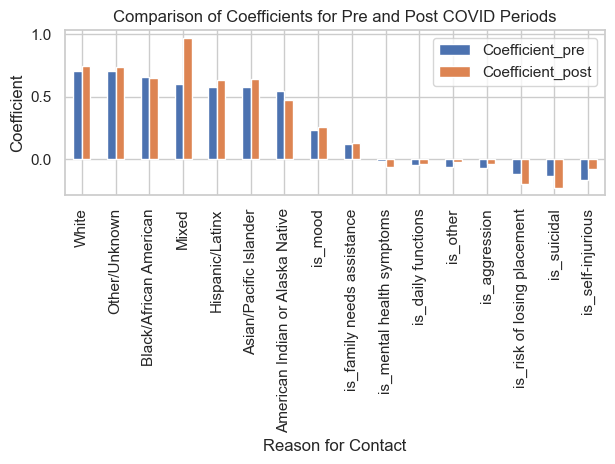

In [241]:
feature_importance_merged.set_index('Feature')[['Coefficient_pre', 'Coefficient_post']].plot(kind='bar')
plt.title('Comparison of Coefficients for Pre and Post COVID Periods')
plt.xlabel('Reason for Contact')
plt.ylabel('Coefficient')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [242]:
list(feature_importance_merged.Feature)

['White',
 'Other/Unknown',
 'Black/African American',
 'Mixed',
 'Hispanic/Latinx',
 'Asian/Pacific Islander',
 'American Indian or Alaska Native',
 'is_mood',
 'is_family needs assistance',
 'is_mental health symptoms',
 'is_daily functions',
 'is_other',
 'is_aggression',
 'is_risk of losing placement',
 'is_suicidal',
 'is_self-injurious']

<Axes: xlabel='Feature'>

Text(0.5, 1.0, 'Comparison of Coefficients for Pre and Post COVID Periods')

Text(0.5, 0, 'Reason for Contact')

Text(0, 0.5, 'Coefficient')

<Axes: xlabel='Feature'>

Text(0.5, 1.0, 'Comparison of P-values for Pre and Post COVID Periods')

Text(0.5, 0, 'Reason for Contact')

Text(0, 0.5, 'P-value')

<Axes: xlabel='Feature'>

Text(0.5, 1.0, 'Comparison of R-values for Pre and Post COVID Periods')

Text(0.5, 0, 'Reason for Contact')

Text(0, 0.5, 'R-value')

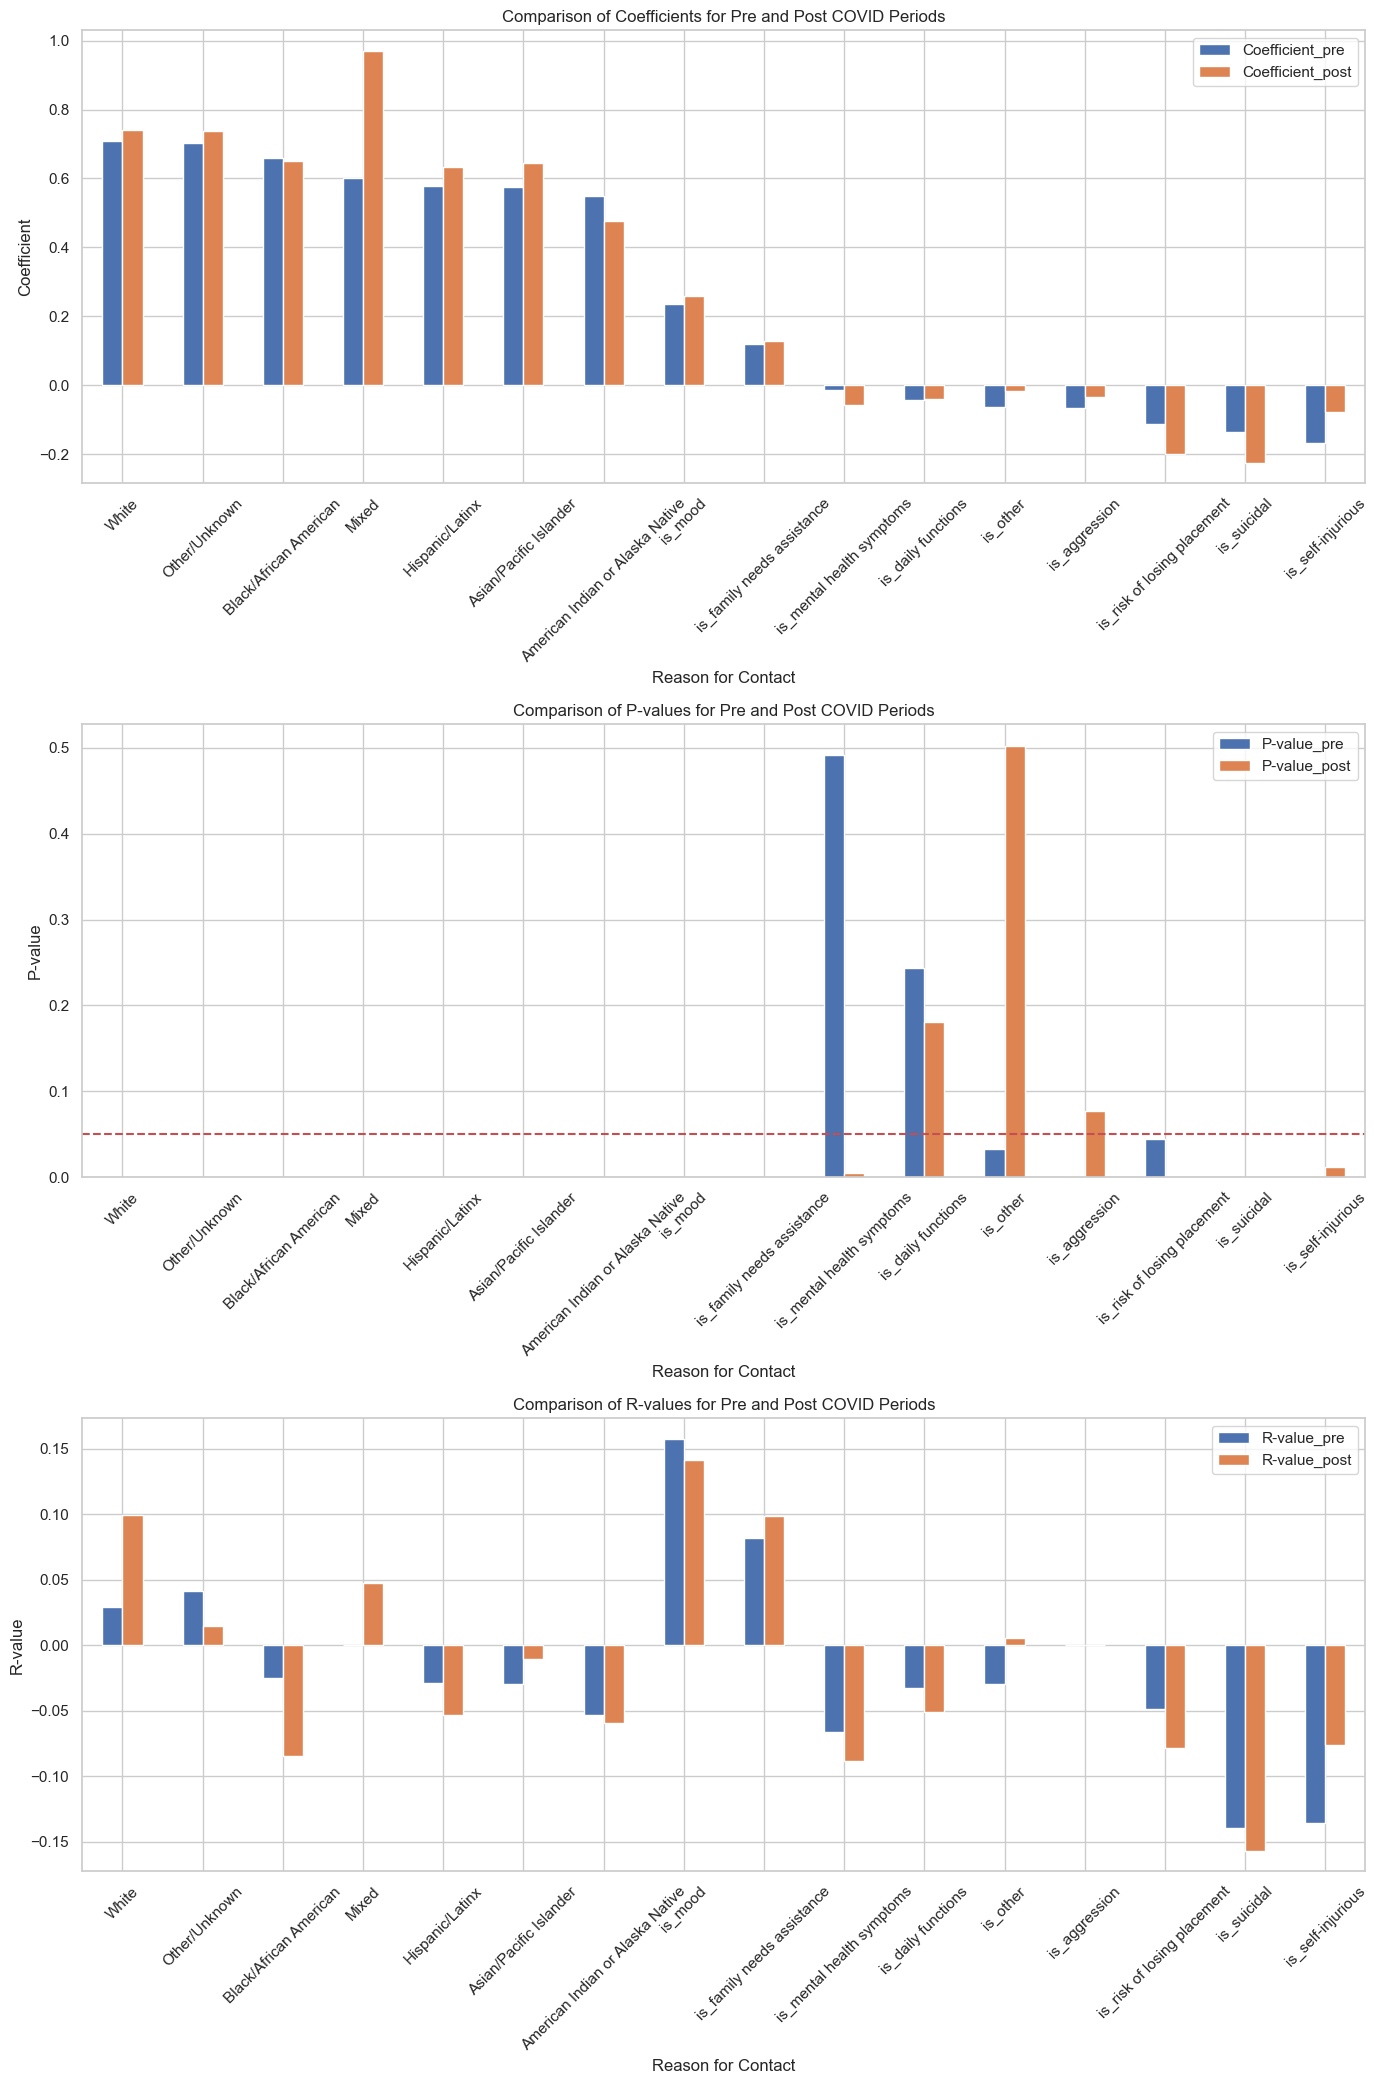

In [243]:
fig, axes = plt.subplots(3, 1, figsize=(14, 21))

# Coefficients
feature_importance_merged.set_index('Feature')[['Coefficient_pre', 'Coefficient_post']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Comparison of Coefficients for Pre and Post COVID Periods')
axes[0].set_xlabel('Reason for Contact')
axes[0].set_ylabel('Coefficient')
axes[0].tick_params(axis='x', rotation=45)

# P-values
feature_importance_merged.set_index('Feature')[['P-value_pre', 'P-value_post']].plot(kind='bar', ax=axes[1])
axes[1].set_title('Comparison of P-values for Pre and Post COVID Periods')
axes[1].set_xlabel('Reason for Contact')
axes[1].set_ylabel('P-value')
axes[1].axhline(y=0.05, color='r', linestyle='--')  # Significance threshold
axes[1].tick_params(axis='x', rotation=45)

# R-values
feature_importance_merged.set_index('Feature')[['R-value_pre', 'R-value_post']].plot(kind='bar', ax=axes[2])
axes[2].set_title('Comparison of R-values for Pre and Post COVID Periods')
axes[2].set_xlabel('Reason for Contact')
axes[2].set_ylabel('R-value')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


<Figure size 1400x700 with 0 Axes>

([<matplotlib.axis.YTick at 0x1694870d0>,
 [Text(0, 0, 'is_White'),
  Text(0, 1, 'is_Other/Unknown'),
  Text(0, 2, 'is_Black/African American'),
  Text(0, 3, 'is_Mixed'),
  Text(0, 4, 'is_Hispanic/Latinx'),
  Text(0, 5, 'is_Asian/Pacific Islander'),
  Text(0, 6, 'is_American Indian or Alaska Native'),
  Text(0, 7, 'is_mood'),
  Text(0, 8, 'is_family needs assistance'),
  Text(0, 9, 'is_mental health symptoms'),
  Text(0, 10, 'is_daily functions'),
  Text(0, 11, 'is_other'),
  Text(0, 12, 'is_aggression'),
  Text(0, 13, 'is_risk of losing placement'),
  Text(0, 14, 'is_suicidal'),
  Text(0, 15, 'is_self-injurious')])

Text(0.5, 0, 'Coefficient')

Text(0.5, 1.0, 'Coefficients for Reasons of Contact - Pre and Post COVID')

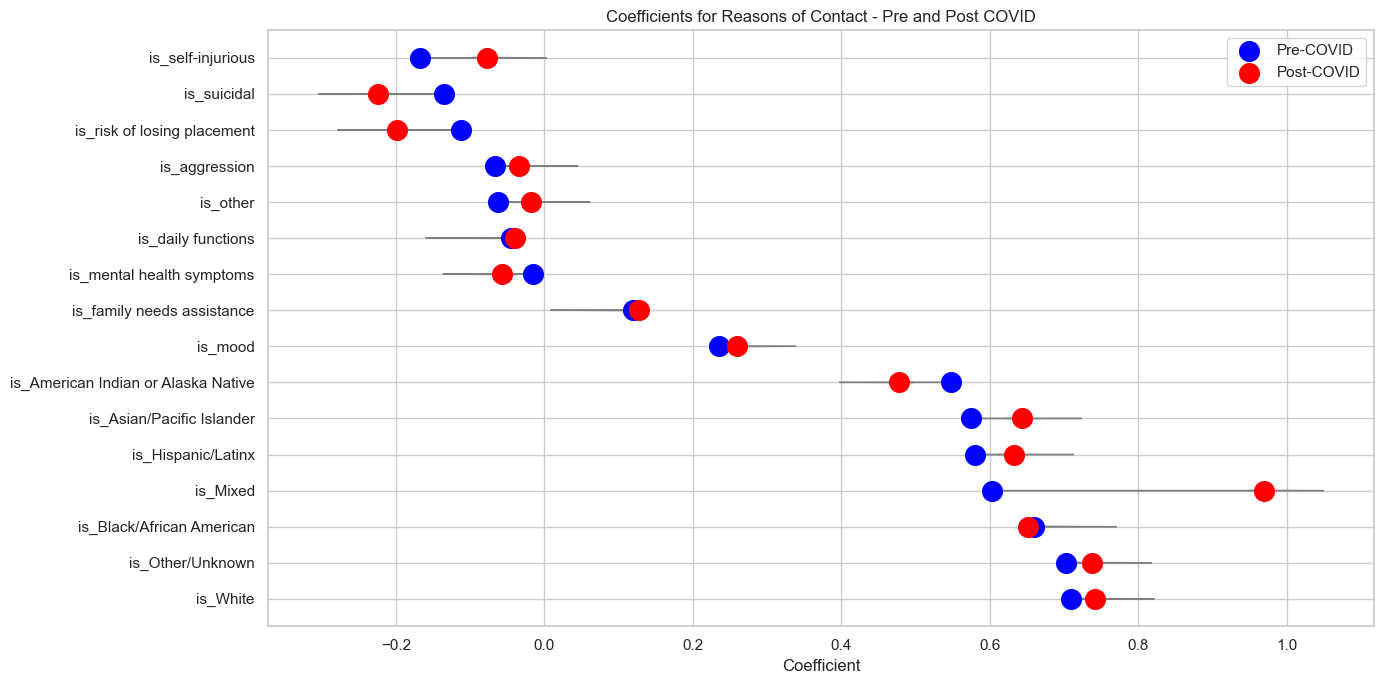

In [187]:
# categories = list(feature_importance_merged['Feature'])
# y = np.arange(len(categories))

# # Create a scatter plot
# plt.figure(figsize=(14, 7))
# ax = plt.gca()

# # Add arrows to show the direction of change
# for i in range(len(y)):
#     if feature_importance_merged['Coefficient_post'][i] < feature_importance_merged['Coefficient_pre'][i]:
#         adjust_dx = 0.02
#     else:
#         adjust_dx = -0.02
#     dx = feature_importance_merged['Coefficient_post'][i] - feature_importance_merged['Coefficient_pre'][i] + adjust_dx
#     ax.arrow(feature_importance_merged['Coefficient_pre'][i], y[i], dx, 0, 
#              head_width=0.02, head_length=0.1, 
#              fc='gray', ec='gray')

# # Scatter plot for pre-COVID coefficients
# ax.scatter(feature_importance_merged['Coefficient_pre'], y, color='blue', label='Pre-COVID', s=200)

# # Scatter plot for post-COVID coefficients
# ax.scatter(feature_importance_merged['Coefficient_post'], y, color='red', label='Post-COVID', s=200)



# # Customize the plot
# plt.yticks(y, categories)
# plt.xlabel('Coefficient')
# plt.title('Coefficients for Reasons of Contact - Pre and Post COVID')
# plt.legend(loc='upper right')
# plt.grid(True)
# plt.tight_layout()

# # Show the plot
# plt.show()

In [246]:
race_features = ['Asian/Pacific Islander', 'White',
       'Hispanic/Latinx', 'American Indian or Alaska Native',
       'Black/African American', 'Other/Unknown', 'Mixed']

In [248]:
X = df_post[race_features].copy()
y = df_post[regression_problem].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

coefficients = model.params
p_values = model.pvalues
feature_names = X.columns

correlations = []
for feature in race_features[1:]:  # Skip the intercept
    correlation = np.corrcoef(X[feature], y)[0, 1]
    correlations.append(correlation)


feature_importance_post_race = pd.DataFrame({
    'Feature': race_features,
    'Coefficient': coefficients,
    'P-value': p_values,
    'R-value': [np.nan] + correlations  # NaN for the intercept correlation
}).sort_values(by='Coefficient', ascending=False)

# print(f"Feature Impact on {regression_problem} in people with IDD in START program:")
feature_importance_post_race

Mean Squared Error: 0.21130361810335982
R^2 Score: 0.026213660216795387


,Feature,Coefficient,P-value,R-value
Mixed,Mixed,0.913043,7.859883e-21,0.047750
Other/Unknown,Other/Unknown,0.721854,1.781439e-76,0.014393
White,White,0.707944,0.000000e+00,0.099497
Asian/Pacific Islander,Asian/Pacific Islander,0.625000,2.590786e-17,NaN
Hispanic/Latinx,Hispanic/Latinx,0.614213,1.393962e-72,-0.053228
Black/African American,Black/African American,0.604374,5.325549e-163,-0.084532
American Indian or Alaska Native,American Indian or Alaska Native,0.428571,5.026082e-08,-0.059007


In [249]:
X = df_pre[race_features].copy()
y = df_pre[regression_problem].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

coefficients = model.params
p_values = model.pvalues
feature_names = X.columns

correlations = []
for feature in race_features[1:]:  # Skip the intercept
    correlation = np.corrcoef(X[feature], y)[0, 1]
    correlations.append(correlation)


feature_importance_pre_race = pd.DataFrame({
    'Feature': race_features,
    'Coefficient': coefficients,
    'P-value': p_values,
    'R-value': [np.nan] + correlations  # NaN for the intercept correlation
}).sort_values(by='Coefficient', ascending=False)

# print(f"Feature Impact on {regression_problem} in people with IDD in START program:")
feature_importance_pre_race

Mean Squared Error: 0.23938670603398945
R^2 Score: -0.005044186444288945


,Feature,Coefficient,P-value,R-value
Other/Unknown,Other/Unknown,0.683168,1.572968e-84,0.041494
White,White,0.659491,0.000000e+00,0.029473
Black/African American,Black/African American,0.601423,1.778987e-166,-0.024811
Mixed,Mixed,0.562500,2.831731e-06,-0.000154
Hispanic/Latinx,Hispanic/Latinx,0.532710,7.889906e-30,-0.028777
Asian/Pacific Islander,Asian/Pacific Islander,0.531250,4.276156e-10,NaN
American Indian or Alaska Native,American Indian or Alaska Native,0.500000,4.128581e-09,-0.053228


In [250]:
feature_importance_merged_race = feature_importance_pre_race.merge(feature_importance_post_race, on='Feature', suffixes = ('_pre', '_post'), how='inner')

In [251]:
feature_importance_merged_race

,Feature,Coefficient_pre,P-value_pre,R-value_pre,Coefficient_post,P-value_post,R-value_post
0,Other/Unknown,0.683168,1.572968e-84,0.041494,0.721854,1.781439e-76,0.014393
1,White,0.659491,0.000000e+00,0.029473,0.707944,0.000000e+00,0.099497
2,Black/African American,0.601423,1.778987e-166,-0.024811,0.604374,5.325549e-163,-0.084532
3,Mixed,0.562500,2.831731e-06,-0.000154,0.913043,7.859883e-21,0.047750
4,Hispanic/Latinx,0.532710,7.889906e-30,-0.028777,0.614213,1.393962e-72,-0.053228
5,Asian/Pacific Islander,0.531250,4.276156e-10,NaN,0.625000,2.590786e-17,NaN
6,American Indian or Alaska Native,0.500000,4.128581e-09,-0.053228,0.428571,5.026082e-08,-0.059007


<Figure size 600x400 with 0 Axes>

Text(0.5, 1.0, 'Comparison of Coefficients for Pre and Post COVID Periods by Race')

Text(0.5, 0, 'Race')

Text(0, 0.5, 'Coefficient')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Other/Unknown'),
  Text(1, 0, 'White'),
  Text(2, 0, 'Black/African American'),
  Text(3, 0, 'Mixed'),
  Text(4, 0, 'Hispanic/Latinx'),
  Text(5, 0, 'Asian/Pacific Islander'),
  Text(6, 0, 'American Indian or Alaska Native')])

<Figure size 600x400 with 0 Axes>

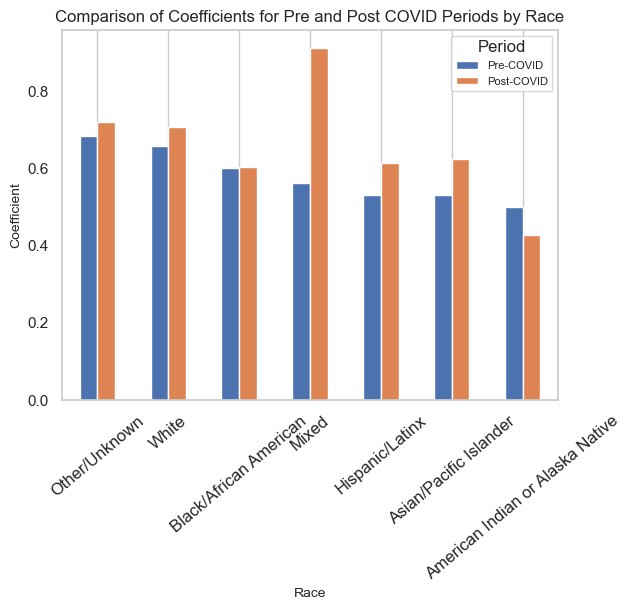

In [291]:
plt.figure(figsize=(6, 4))  # Increase figure size

# Plotting the coefficients for pre and post-COVID periods based on race
ax = feature_importance_merged_race.set_index('Feature')[['Coefficient_pre', 'Coefficient_post']].plot(kind='bar')
plt.title('Comparison of Coefficients for Pre and Post COVID Periods by Race', fontsize=12)  # Adjust title fontsize
plt.xlabel('Race', fontsize=10)  # Adjust xlabel fontsize
plt.ylabel('Coefficient', fontsize=10)  # Adjust ylabel fontsize
plt.xticks(rotation=40, fontsize=12)  # Adjust xticks fontsize and rotation
plt.legend(title='Period', labels=['Pre-COVID', 'Post-COVID'], fontsize=8)  # Adjust legend fontsize
plt.grid(axis='y')

# Export the plot to a PNG file
plt.savefig('coeff_race_comparison.png', bbox_inches='tight')  # Use bbox_inches='tight' to prevent cutoff
plt.show()


<Figure size 1200x800 with 0 Axes>

<Axes: xlabel='Feature'>

Text(0.5, 1.0, 'Comparison of P-values for Pre and Post COVID Periods by Race')

Text(0.5, 0, 'Race')

Text(0, 0.5, 'P-value')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Other/Unknown'),
  Text(1, 0, 'White'),
  Text(2, 0, 'Black/African American'),
  Text(3, 0, 'Mixed'),
  Text(4, 0, 'Hispanic/Latinx'),
  Text(5, 0, 'Asian/Pacific Islander'),
  Text(6, 0, 'American Indian or Alaska Native')])

<Figure size 1200x800 with 0 Axes>

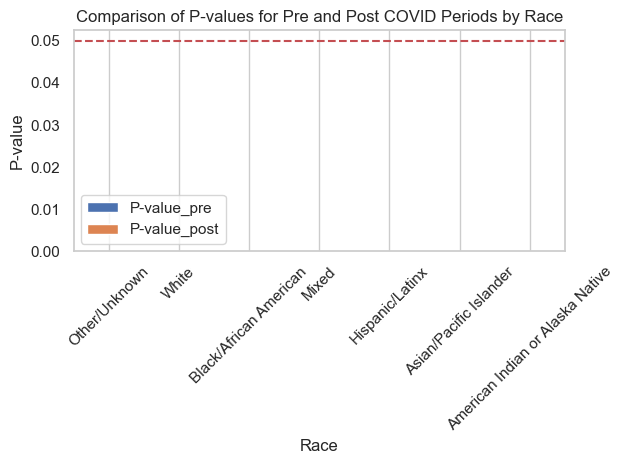

<Figure size 640x480 with 0 Axes>

In [274]:
plt.figure(figsize=(12, 8))

# Plotting the P-values for pre and post-COVID periods based on race
feature_importance_merged_race.set_index('Feature')[['P-value_pre', 'P-value_post']].plot(kind='bar')
plt.title('Comparison of P-values for Pre and Post COVID Periods by Race')
plt.xlabel('Race')
plt.ylabel('P-value')
plt.axhline(y=0.05, color='r', linestyle='--')  # Significance threshold
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


<Figure size 10000x6000 with 0 Axes>

Text(0.5, 1.0, 'Comparison of R-values for Pre and Post COVID Periods by Race')

Text(0.5, 0, 'Race')

Text(0, 0.5, 'R-value')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'is_White'),
  Text(1, 0, 'is_Other/Unknown'),
  Text(2, 0, 'is_Black/African American'),
  Text(3, 0, 'is_Mixed'),
  Text(4, 0, 'is_Hispanic/Latinx'),
  Text(5, 0, 'is_Asian/Pacific Islander'),
  Text(6, 0, 'is_American Indian or Alaska Native')])

<Figure size 10000x6000 with 0 Axes>

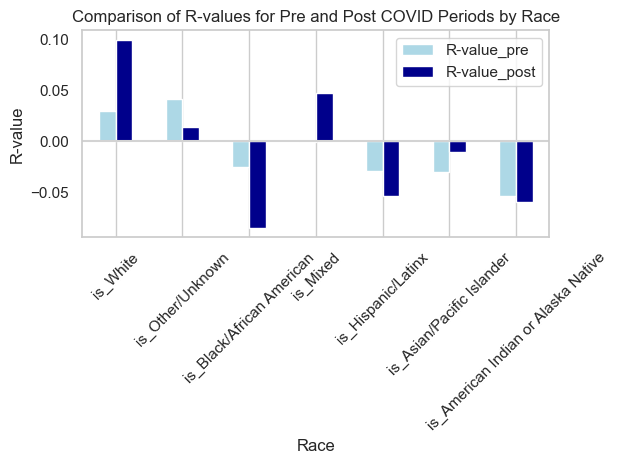

In [278]:
plt.figure(figsize=(10, 6), dpi=1000)

# Define custom colors for the bars
colors = ['lightblue', 'darkblue']  # Blue for pre-COVID, Purple for post-COVID

# Plotting the R-values for pre and post-COVID periods based on race with custom colors
ax = race_merged.set_index('Feature')[['R-value_pre', 'R-value_post']].plot(kind='bar', color=colors)

plt.title('Comparison of R-values for Pre and Post COVID Periods by Race')
plt.xlabel('Race')
plt.ylabel('R-value')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add a horizontal line at y=0
ax.axhline(y=0, color='lightgray', linestyle='-')

plt.tight_layout()

plt.savefig('r_values_comparison.png')
plt.show()

In [294]:

race_merged = feature_importance_merged[feature_importance_merged.Feature.isin(race_features) == True]
race_merged


,Feature,Coefficient_pre,P-value_pre,R-value_pre,Coefficient_post,P-value_post,R-value_post
0,White,0.709054,2.556254e-166,0.029473,0.741791,1.065120e-213,0.099497
1,Other/Unknown,0.703358,1.422194e-68,0.041494,0.738130,2.385291e-67,0.014393
2,Black/African American,0.659423,2.393686e-103,-0.024811,0.650886,1.399232e-109,-0.084532
3,Mixed,0.602576,2.741535e-07,-0.000154,0.969794,3.451748e-24,0.047750
4,Hispanic/Latinx,0.579491,6.220011e-31,-0.028777,0.633130,3.844922e-61,-0.053228
5,Asian/Pacific Islander,0.574812,1.801578e-11,-0.029772,0.644101,5.930736e-18,-0.010724
6,American Indian or Alaska Native,0.548128,1.698300e-10,-0.053228,0.477170,1.454949e-09,-0.059007


<Axes: xlabel='Feature'>

Text(0.5, 1.0, 'Comparison of Coefficients for Pre and Post COVID Periods')

Text(0.5, 0, 'Reason for Contact')

Text(0, 0.5, 'Coefficient')

<Axes: xlabel='Feature'>

Text(0.5, 1.0, 'Comparison of P-values for Pre and Post COVID Periods')

Text(0.5, 0, 'Reason for Contact')

Text(0, 0.5, 'P-value')

<Axes: xlabel='Feature'>

Text(0.5, 1.0, 'Comparison of R-values for Pre and Post COVID Periods')

Text(0.5, 0, 'Reason for Contact')

Text(0, 0.5, 'R-value')

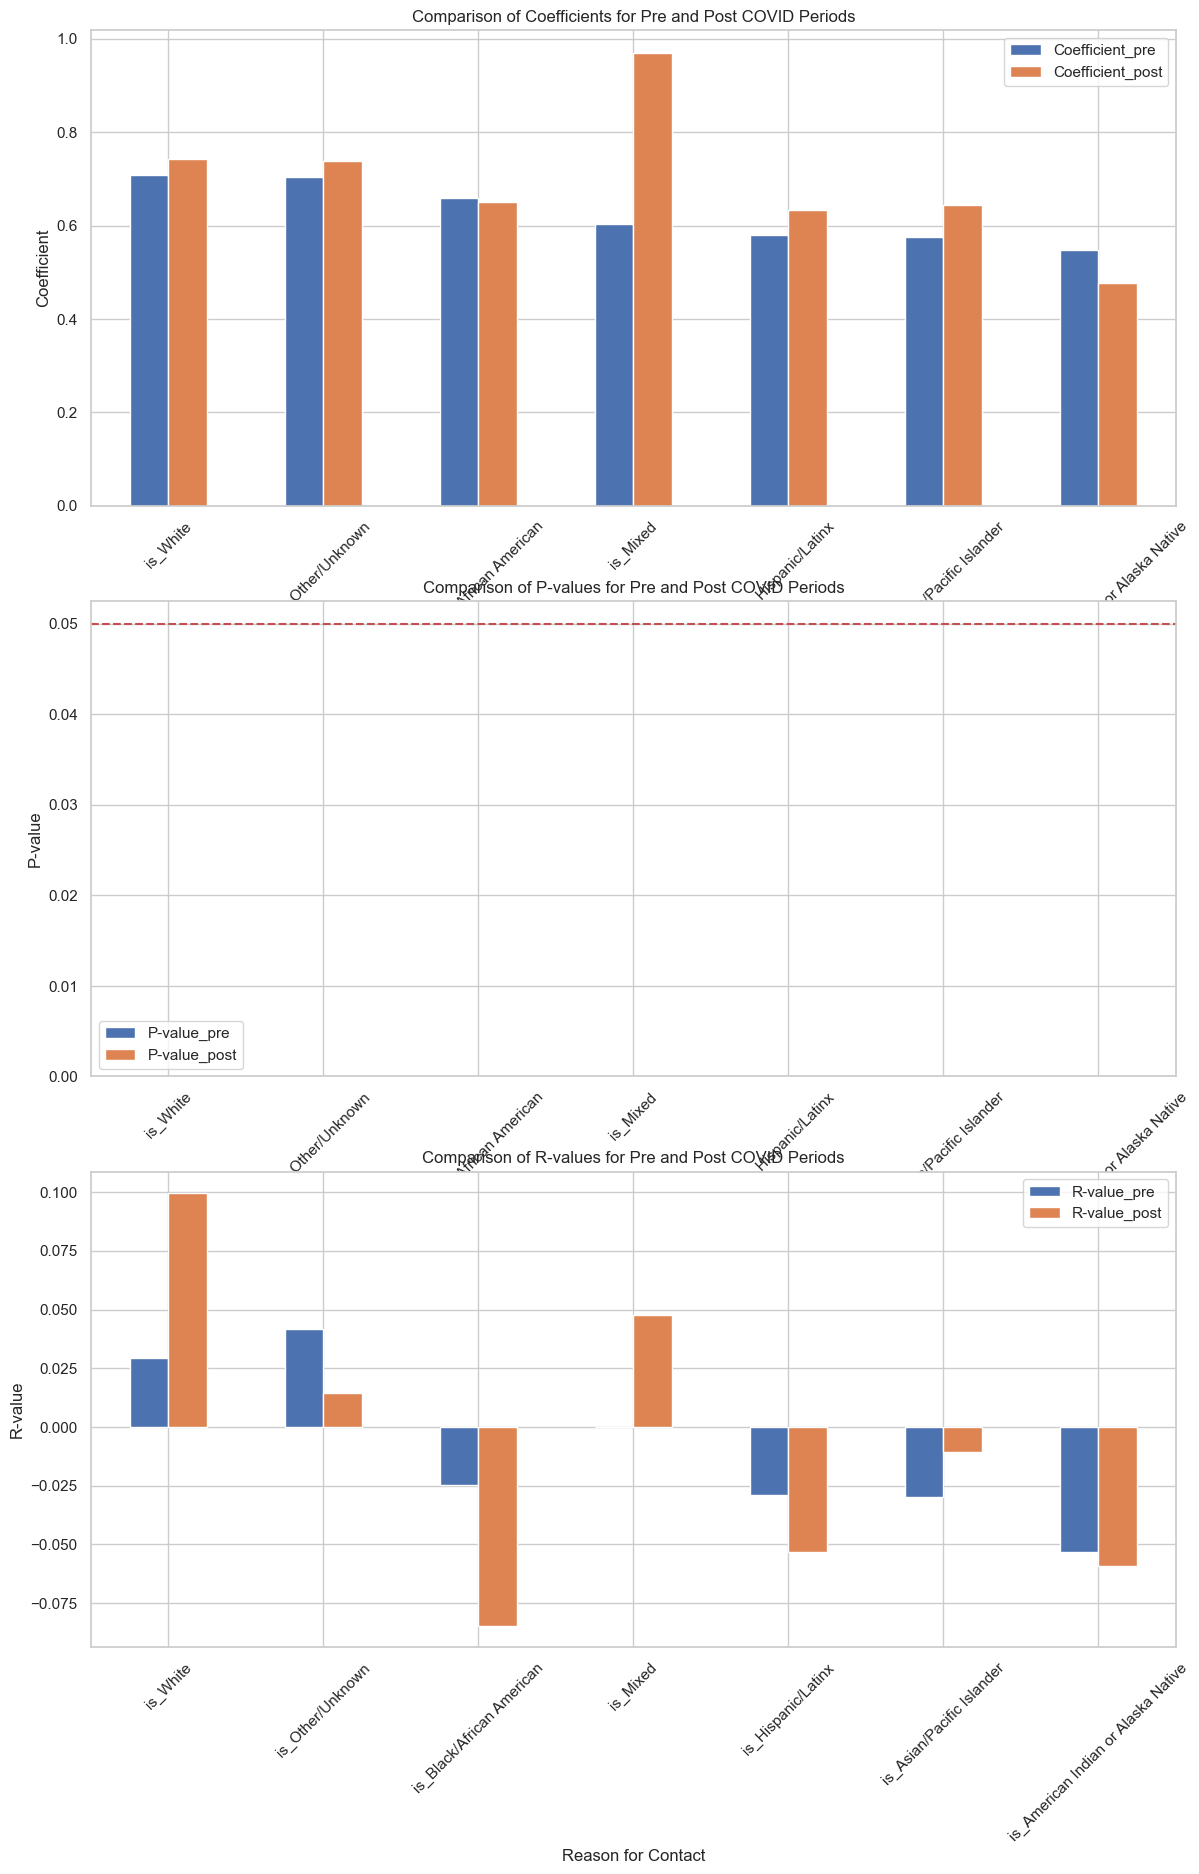

In [220]:
fig, axes = plt.subplots(3, 1, figsize=(14, 21))

# Coefficients
race_merged.set_index('Feature')[['Coefficient_pre', 'Coefficient_post']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Comparison of Coefficients for Pre and Post COVID Periods')
axes[0].set_xlabel('Reason for Contact')
axes[0].set_ylabel('Coefficient')
axes[0].tick_params(axis='x', rotation=45)

# P-values
race_merged.set_index('Feature')[['P-value_pre', 'P-value_post']].plot(kind='bar', ax=axes[1])
axes[1].set_title('Comparison of P-values for Pre and Post COVID Periods')
axes[1].set_xlabel('Reason for Contact')
axes[1].set_ylabel('P-value')
axes[1].axhline(y=0.05, color='r', linestyle='--')  # Significance threshold
axes[1].tick_params(axis='x', rotation=45)

# R-values
race_merged.set_index('Feature')[['R-value_pre', 'R-value_post']].plot(kind='bar', ax=axes[2])
axes[2].set_title('Comparison of R-values for Pre and Post COVID Periods')
axes[2].set_xlabel('Reason for Contact')
axes[2].set_ylabel('R-value')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [326]:
reason_features = ['is_aggression', 'is_mental health',
       'is_family needs assistance', 'is_suicidal', 'is_self-injurious',
       'is_daily functions', 'is_risk of losing placement', 'is_mood',
       'is_other']

In [337]:
X = df_post[reason_features].copy()
y = df_post[regression_problem].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

coefficients = model.params
p_values = model.pvalues
feature_names = X.columns

correlations = []
for feature in reason_features[1:]:  # Skip the intercept
    correlation = np.corrcoef(X[feature], y)[0, 1]
    correlations.append(correlation)


feature_importance_post_reason = pd.DataFrame({
    'Feature': reason_features,
    'Coefficient': coefficients,
    'P-value': p_values,
    'R-value': [np.nan] + correlations  # NaN for the intercept correlation
}).sort_values(by='Coefficient', ascending=False)

# print(f"Feature Impact on {regression_problem} in people with IDD in START program:")
feature_importance_post_reason = feature_importance_post_reason.reset_index(drop=True)
feature_importance_post_reason

Mean Squared Error: 0.2995337774528593
R^2 Score: -0.38039236339332216


,Feature,Coefficient,P-value,R-value
0,is_mood,0.568265,1.324386e-35,0.141662
1,is_other,0.472864,4.872290e-63,0.005526
2,is_aggression,0.428709,5.346978e-131,NaN
3,is_family needs assistance,0.369241,1.438469e-50,0.098462
4,is_mental health symptoms,0.257333,1.658465e-32,-0.088182
5,is_daily functions,0.214899,6.706017e-10,-0.051017
6,is_self-injurious,0.041436,2.585708e-01,-0.075862
7,is_suicidal,0.024195,5.000338e-01,-0.156709
8,is_risk of losing placement,-0.139482,2.329724e-02,-0.078688


In [344]:
X = df_pre[reason_features].copy()
y = df_pre[regression_problem].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

coefficients = model.params
p_values = model.pvalues
feature_names = X.columns

correlations = []
for feature in reason_features[1:]:  # Skip the intercept
    correlation = np.corrcoef(X[feature], y)[0, 1]
    correlations.append(correlation)


feature_importance_pre_reason = pd.DataFrame({
    'Feature': reason_features,
    'Coefficient': coefficients,
    'P-value': p_values,
    'R-value': [np.nan] + correlations  # NaN for the intercept correlation
}).sort_values(by='Coefficient', ascending=False)

# print(f"Feature Impact on {regression_problem} in people with IDD in START program:")
feature_importance_pre_reason = feature_importance_pre_reason.reset_index(drop=True)
feature_importance_pre_reason.sort_index(axis=0)
feature_importance_post_reason.sort_index(axis=0)

Mean Squared Error: 0.3106079960180418
R^2 Score: -0.3040605547106674


,Feature,Coefficient,P-value,R-value
0,is_mood,0.499515,4.661206e-47,0.157319
1,is_aggression,0.391221,1.658154e-107,NaN
2,is_family needs assistance,0.338600,2.372836e-38,0.082049
3,is_other,0.330893,5.085521e-27,-0.029843
4,is_mental health symptoms,0.280727,5.868125e-35,-0.066085
5,is_suicidal,0.140262,1.304250e-05,-0.139736
6,is_daily functions,0.044274,3.150195e-01,-0.032451
7,is_risk of losing placement,-0.101064,1.213730e-01,-0.048570
8,is_self-injurious,-0.112753,7.531284e-04,-0.135467


,Feature,Coefficient,P-value,R-value
0,is_mood,0.568265,1.324386e-35,0.141662
1,is_other,0.472864,4.872290e-63,0.005526
2,is_aggression,0.428709,5.346978e-131,NaN
3,is_family needs assistance,0.369241,1.438469e-50,0.098462
4,is_mental health symptoms,0.257333,1.658465e-32,-0.088182
5,is_daily functions,0.214899,6.706017e-10,-0.051017
6,is_self-injurious,0.041436,2.585708e-01,-0.075862
7,is_suicidal,0.024195,5.000338e-01,-0.156709
8,is_risk of losing placement,-0.139482,2.329724e-02,-0.078688


In [345]:
feature_importance_merged_reason = feature_importance_pre_reason.merge(feature_importance_post_reason, on='Feature', suffixes = ('_pre', '_post'), how='inner')

<Figure size 600x400 with 0 Axes>

Text(0.5, 1.0, 'Comparison of Coefficients for Pre and Post COVID Periods by Reason for Contact')

Text(0.5, 0, 'Reason for Contact')

Text(0, 0.5, 'Coefficient')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'is_mood'),
  Text(1, 0, 'is_aggression'),
  Text(2, 0, 'is_family needs assistance'),
  Text(3, 0, 'is_other'),
  Text(4, 0, 'is_mental health symptoms'),
  Text(5, 0, 'is_suicidal'),
  Text(6, 0, 'is_daily functions'),
  Text(7, 0, 'is_risk of losing placement'),
  Text(8, 0, 'is_self-injurious')])

<Figure size 600x400 with 0 Axes>

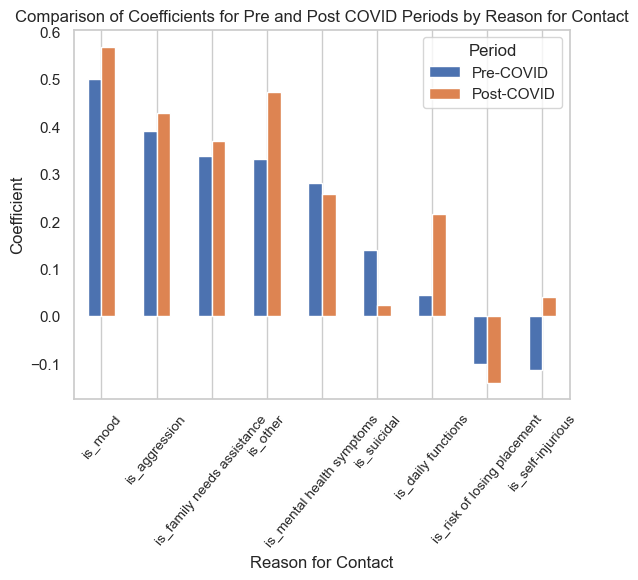

In [363]:
plt.figure(figsize=(6, 4))  # Increase figure size

# Plotting the coefficients for pre and post-COVID periods based on race
ax = feature_importance_merged_reason.set_index('Feature')[['Coefficient_pre', 'Coefficient_post']].plot(kind='bar')
plt.title('Comparison of Coefficients for Pre and Post COVID Periods by Reason for Contact')  # Adjust title fontsize
plt.xlabel('Reason for Contact')  # Adjust xlabel fontsize
plt.ylabel('Coefficient')  # Adjust ylabel fontsize
plt.xticks(rotation=50, fontsize= 10)  # Adjust xticks fontsize and rotation
plt.legend(title='Period', labels=['Pre-COVID', 'Post-COVID'])  # Adjust legend fontsize
plt.grid(axis='y')

# Export the plot to a PNG file
plt.savefig('coeff_reason_comparison.png', bbox_inches='tight')  # Use bbox_inches='tight' to prevent cutoff
plt.show()


<Axes: xlabel='Feature'>

Text(0.5, 1.0, 'Comparison of Coefficients for Pre and Post COVID Periods')

Text(0.5, 0, 'Reason for Contact')

Text(0, 0.5, 'Coefficient')

<Axes: xlabel='Feature'>

Text(0.5, 1.0, 'Comparison of P-values for Pre and Post COVID Periods')

Text(0.5, 0, 'Reason for Contact')

Text(0, 0.5, 'P-value')

<Axes: xlabel='Feature'>

Text(0.5, 1.0, 'Comparison of R-values for Pre and Post COVID Periods')

Text(0.5, 0, 'Reason for Contact')

Text(0, 0.5, 'R-value')

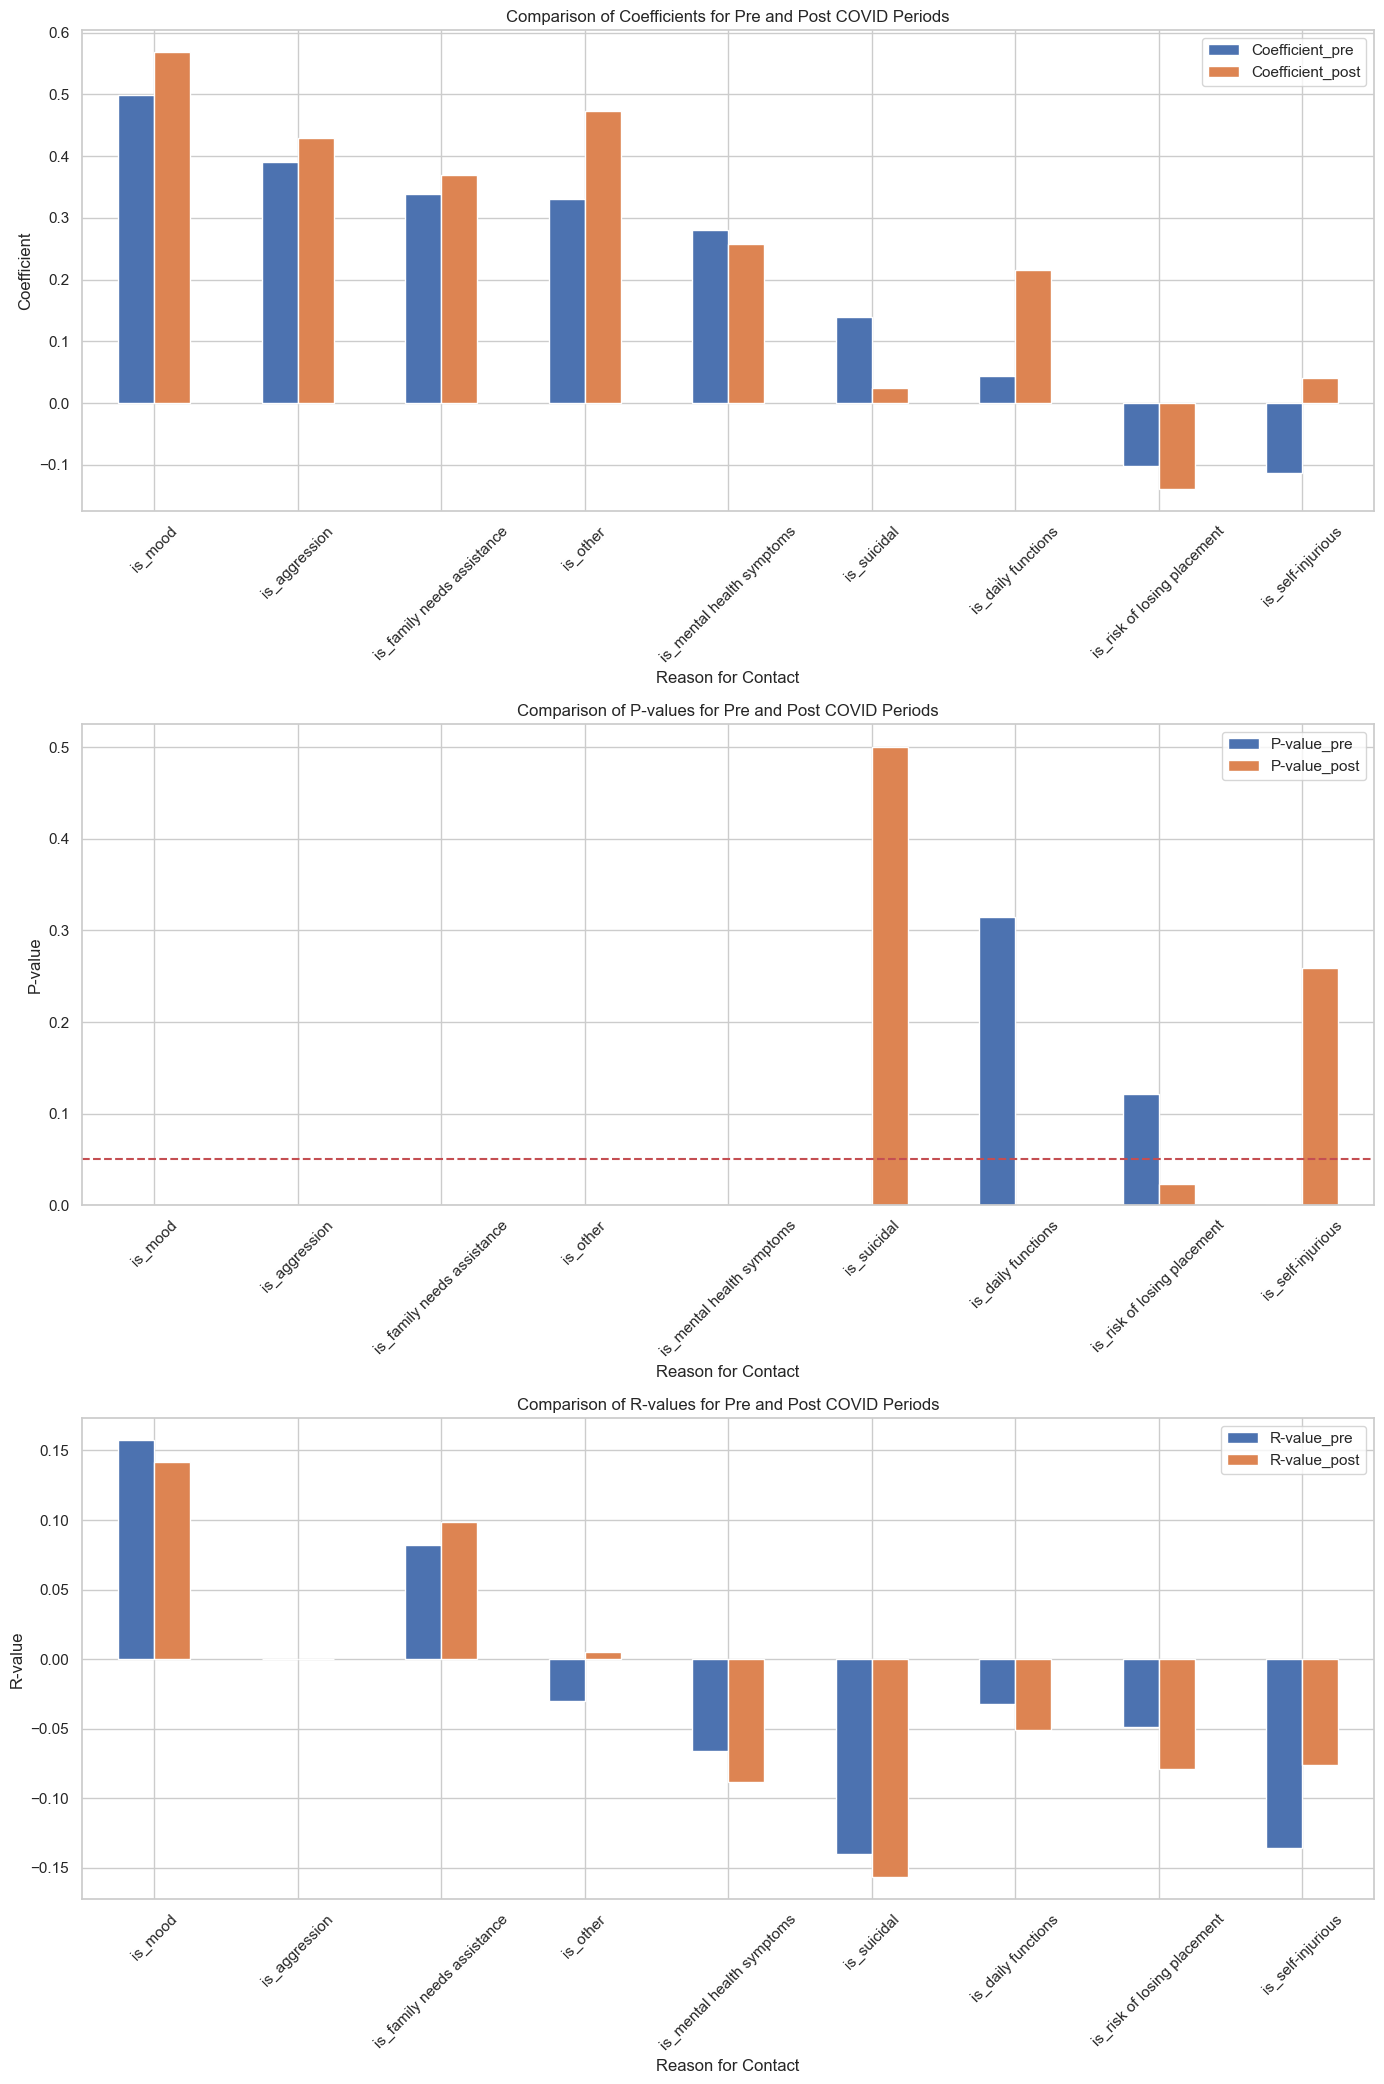

In [364]:
fig, axes = plt.subplots(3, 1, figsize=(14, 21))

# Coefficients
feature_importance_merged_reason.set_index('Feature')[['Coefficient_pre', 'Coefficient_post']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Comparison of Coefficients for Pre and Post COVID Periods')
axes[0].set_xlabel('Reason for Contact')
axes[0].set_ylabel('Coefficient')
axes[0].tick_params(axis='x', rotation=45)

# P-values
feature_importance_merged_reason.set_index('Feature')[['P-value_pre', 'P-value_post']].plot(kind='bar', ax=axes[1])
axes[1].set_title('Comparison of P-values for Pre and Post COVID Periods')
axes[1].set_xlabel('Reason for Contact')
axes[1].set_ylabel('P-value')
axes[1].axhline(y=0.05, color='r', linestyle='--')  # Significance threshold
axes[1].tick_params(axis='x', rotation=45)

# R-values
feature_importance_merged_reason.set_index('Feature')[['R-value_pre', 'R-value_post']].plot(kind='bar', ax=axes[2])
axes[2].set_title('Comparison of R-values for Pre and Post COVID Periods')
axes[2].set_xlabel('Reason for Contact')
axes[2].set_ylabel('R-value')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


<Figure size 1400x700 with 0 Axes>

<Axes: xlabel='Feature'>

Text(0.5, 1.0, 'Comparison of P-values for Pre and Post COVID Periods by Reason for Contact')

Text(0.5, 0, 'Reason for Contact')

Text(0, 0.5, 'P-value')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'is_mood'),
  Text(1, 0, 'is_aggression'),
  Text(2, 0, 'is_family needs assistance'),
  Text(3, 0, 'is_other'),
  Text(4, 0, 'is_mental health symptoms'),
  Text(5, 0, 'is_suicidal'),
  Text(6, 0, 'is_daily functions'),
  Text(7, 0, 'is_risk of losing placement'),
  Text(8, 0, 'is_self-injurious')])

<Figure size 1400x700 with 0 Axes>

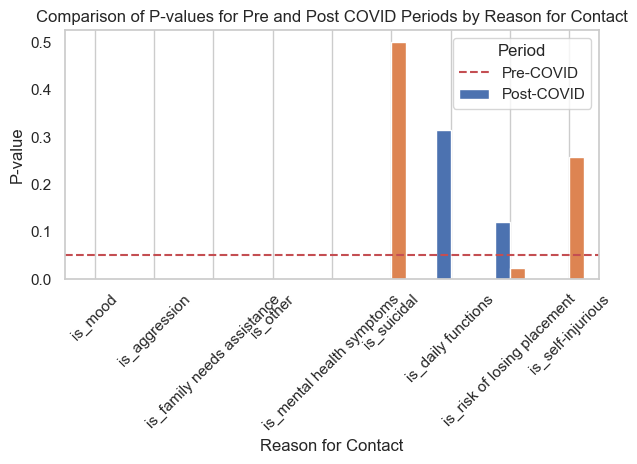

In [365]:
plt.figure(figsize=(14, 7))

# Plotting the P-values for pre and post-COVID periods based on reasons for contact
feature_importance_merged_reason.set_index('Feature')[['P-value_pre', 'P-value_post']].plot(kind='bar')
plt.title('Comparison of P-values for Pre and Post COVID Periods by Reason for Contact')
plt.xlabel('Reason for Contact')
plt.ylabel('P-value')
plt.axhline(y=0.05, color='r', linestyle='--')  # Significance threshold
plt.xticks(rotation=45)
plt.legend(title='Period', labels=['Pre-COVID', 'Post-COVID'])
plt.grid(axis='y')

# Save the plot as an image
plt.tight_layout()
plt.savefig('p_values_reason_comparison.png')

# Show the plot
plt.show()